# Analysis of Benchmarking results in R

In [2]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr)
    library(data.table)
    library(bench)
})

In [18]:
# load and rowbind all benchmarking data
files <- list.files("results", pattern = "\\.csv$", full.names = TRUE)
all_data <- lapply(files, function(file) {
    fread(file, data.table = FALSE) %>%
        mutate(tool = tools::file_path_sans_ext(basename(file)))
}) %>%
    bind_rows() %>%
    relocate(tool) %>%
    mutate(tool = as.factor(tool), mem_alloc = as_bench_bytes(mem_alloc)) %>%
    mutate(across(where(is.character), bench::as_bench_time))

print(levels(all_data$tool))
print(dim(all_data))

[1] "immunarch"       "scRepertoire1"   "scRepertoire1_2" "scRepertoire2"  
[1] 27 22


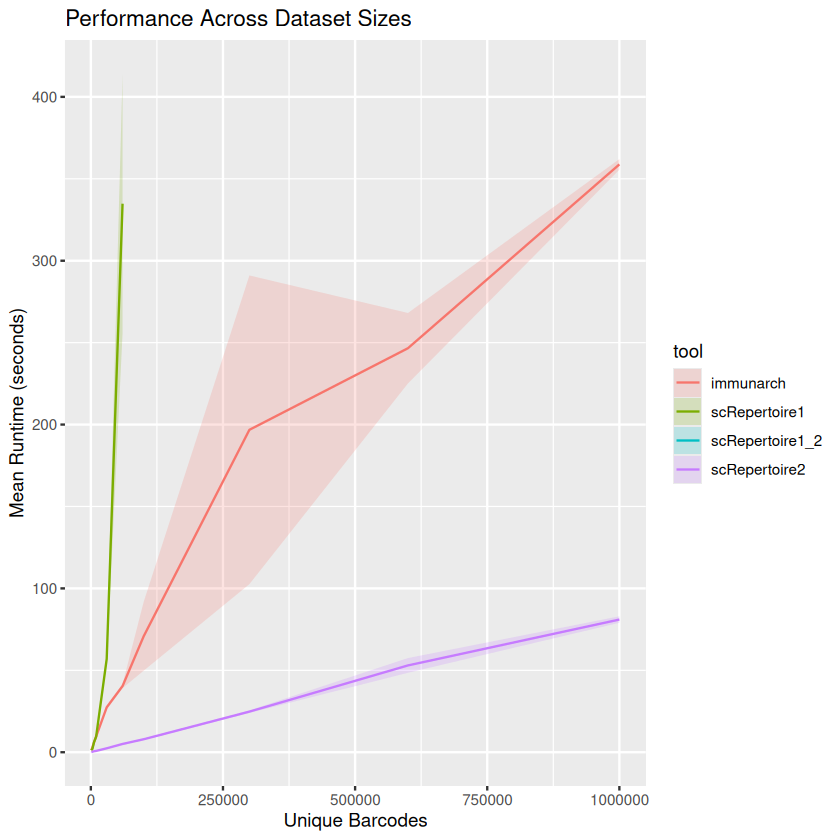

In [19]:
ggplot(all_data, aes(x = dataset_size, y = mean, color = tool, fill = tool)) +
  geom_line() +
  geom_ribbon(aes(ymin = mean - ci95, ymax = mean + ci95), alpha = 0.2, color = NA) +
  labs(x = "Unique Barcodes", y = "Mean Runtime (seconds)", title = "Performance Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

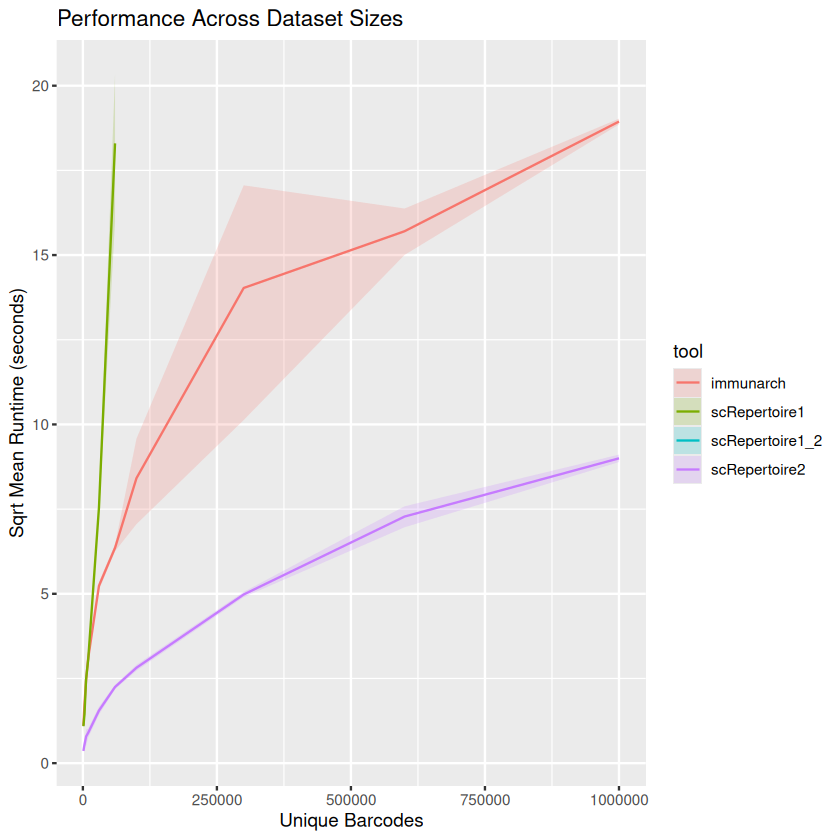

In [40]:
ggplot(all_data, aes(x = dataset_size, y = sqrt(mean), color = tool, fill = tool)) +
  geom_line() +
  geom_ribbon(aes(ymin = sqrt(mean - ci95), ymax = sqrt(mean + ci95)), alpha = 0.2, color = NA) +
  labs(x = "Unique Barcodes", y = "Sqrt Mean Runtime (seconds)", title = "Performance Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

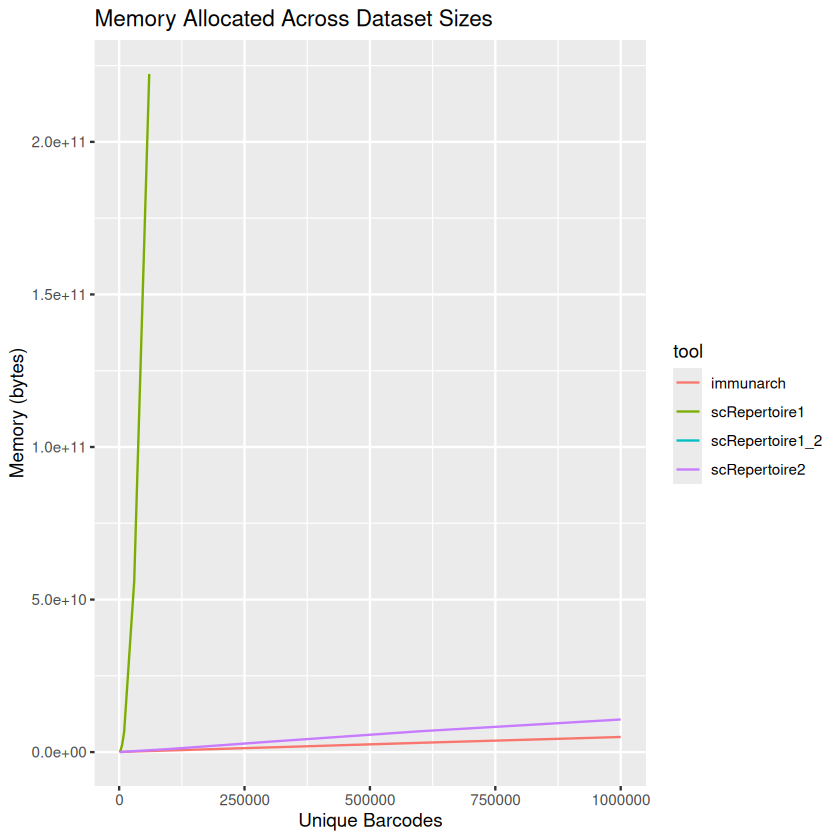

In [41]:
ggplot(all_data, aes(x = dataset_size, y = mem_alloc, color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Unique Barcodes", y = "Memory (bytes)", title = "Memory Allocated Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

In [ ]:
ggplot(all_data, aes(x = dataset_size, y = sqrt(mean), color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Unique Barcodes", y = "Memory (bytes)", title = "Memory Allocated Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

In [35]:
# fitting a quadratic model for the memory usage of scRep1
scRep1 <- all_data %>%
    filter(tool == "scRepertoire1") %>%
    mutate(log_dataset_size = log(as.numeric(dataset_size))) %>%
    mutate(log_mem_alloc = log(as.numeric(mem_alloc))) %>%
    select(dataset_size, log_dataset_size, mem_alloc, log_mem_alloc)
scRep1

dataset_size,log_dataset_size,mem_alloc,log_mem_alloc
<int>,<dbl>,<bch:byt>,<dbl>
1000,6.907755,76.4MB,18.19893
3000,8.006368,590MB,20.24307
6000,8.699515,2.25GB,21.60535
10000,9.210340,6.14GB,22.60924
30000,10.308953,52GB,24.74566
60000,11.002100,207GB,26.12713


In [36]:
m <- lm(log_mem_alloc ~ 1 + log_dataset_size, data = scRep1)
predict_mem_alloc <- function(dataset_size) {
    log_dataset_size <- log(as.numeric(dataset_size))
    as_bench_bytes(exp(predict(m, data.frame(log_dataset_size = log_dataset_size))))
}
predict_mem_alloc(50000)

1 
141GB

[1] 0.999957

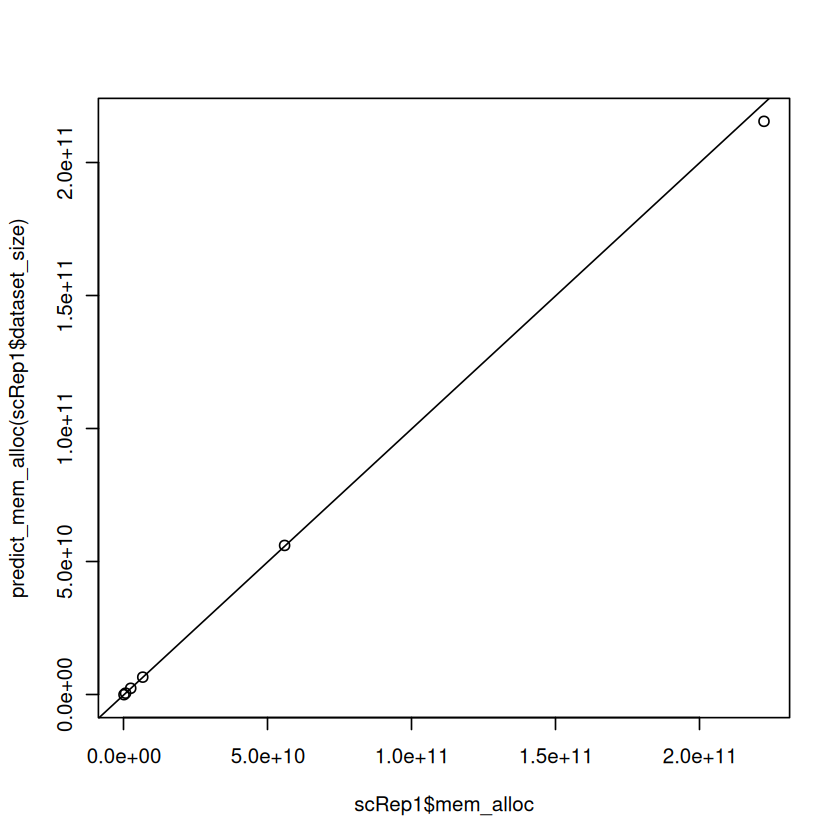

In [37]:
plot(scRep1$mem_alloc, predict_mem_alloc(scRep1$dataset_size))
abline(0, 1)
cor(scRep1$mem_alloc, predict_mem_alloc(scRep1$dataset_size))